# ALL-IDB Classification using Autoencoder

### Dataset used:- [ALL-IDB:Acute Lymphoblastic Leukemia Image Database for Image Processing](https://homes.di.unimi.it/scotti/all/)
Follow the instructions provided in the linked website to download the dataset. After downloading, extract the files to the current directory (same folder as your codes). Note that ALL_IDB2 is used in this  tutorial.

In [1]:
%matplotlib inline
import os
import struct
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torch.autograd import Variable
from torch.utils.data import TensorDataset,DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
import time
import random

### Load Data:

In [2]:
Datapath = 'C:/Users/USER/Desktop/ALL_IDB2/ALL_IDB2/img/'
listing = os.listdir(Datapath) 
random.shuffle(listing)

In [3]:
# ALL_IDB2 dataset has 260 images in total
TrainImages = torch.FloatTensor(200,3072)
TrainLabels = torch.LongTensor(200)
TestImages = torch.FloatTensor(60,3072)
TestLabels = torch.LongTensor(60)

# First 200 images are used for training and the remaining 60 for testing
img_no = 0
for file in listing:
    im=Image.open(Datapath + file)
    im = im.resize((32,32))
    im = np.array(im)
    im = np.reshape(im, 32*32*3)
    if img_no < 200:
        TrainImages[img_no] = torch.from_numpy(im)
        TrainLabels[img_no] = int(listing[img_no][6:7])
    else:
        TestImages[img_no - 200] = torch.from_numpy(im)
        TestLabels[img_no - 200] = int(listing[img_no][6:7])
    img_no = img_no + 1

In [4]:
print(TrainImages.size())
print(TrainLabels.size())
print(TestImages.size())
print(TestLabels.size())

torch.Size([200, 3072])
torch.Size([200])
torch.Size([60, 3072])
torch.Size([60])


In [5]:
# Creating pytorch dataset from the feature matices
trainDataset = TensorDataset(TrainImages, TrainLabels)
testDataset = TensorDataset(TestImages, TestLabels)
# Creating dataloader
BatchSize = 16
trainLoader = DataLoader(trainDataset, batch_size=BatchSize, shuffle=True,num_workers=4, pin_memory=True)
testLoader = DataLoader(testDataset, batch_size=BatchSize, shuffle=True,num_workers=4, pin_memory=True)

In [6]:
# Check availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')

### Define the Autoencoder class

In [7]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(32*32*3, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU())
#             nn.Linear(500, 100),
#             nn.ReLU())
        self.decoder = nn.Sequential(
#             nn.Linear(100, 500),
#             nn.ReLU(),
            nn.Linear(500, 1000),
            nn.ReLU(),
            nn.Linear(1000, 32*32*3),
            nn.ReLU())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Initialize the network

In [8]:
net = autoencoder()
print(net)

if use_gpu:
    net = net.cuda()

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=500, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=500, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=3072, bias=True)
    (3): ReLU()
  )
)


### Define optimization technique:

In [9]:
criterion = nn.MSELoss() # Mean Squared Error 
optimizer = optim.Adam(net.parameters(), lr=1e-3)#, momentum=0.9) # Stochastic Gradient Descent

### Training the autoencoder for representaion learning

In [10]:
iterations = 20
for epoch in range(iterations):   
    net.train(True) # For training
    runningLoss = 0
    for batch_num,data in enumerate(trainLoader):
        inputs,_  = data # Labels are not required 
        inputs = inputs/255
        if use_gpu:
            inputs = Variable(inputs).cuda()
        else:
            inputs = Variable(inputs)
        # Initialize the gradients to zero
        optimizer.zero_grad()
        # Feed forward the input data through the network
        outputs = net(inputs)
        # Compute the error/loss
        loss = criterion(outputs, inputs)
        # Backpropagate the loss to compute gradients
        loss.backward()
        # Update model parameters
        optimizer.step()
        # Accumulate loss per batch
        runningLoss += loss.data
    # Printing average loss per epoch
    print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,runningLoss/
                                                                (TrainImages.size()[0]/BatchSize)))

At Iteration : 1 / 20  ;  Mean-Squared Error : 0.136298
At Iteration : 2 / 20  ;  Mean-Squared Error : 0.078614
At Iteration : 3 / 20  ;  Mean-Squared Error : 0.071790
At Iteration : 4 / 20  ;  Mean-Squared Error : 0.070829
At Iteration : 5 / 20  ;  Mean-Squared Error : 0.070107
At Iteration : 6 / 20  ;  Mean-Squared Error : 0.070178
At Iteration : 7 / 20  ;  Mean-Squared Error : 0.070239
At Iteration : 8 / 20  ;  Mean-Squared Error : 0.070459
At Iteration : 9 / 20  ;  Mean-Squared Error : 0.070559
At Iteration : 10 / 20  ;  Mean-Squared Error : 0.070628
At Iteration : 11 / 20  ;  Mean-Squared Error : 0.069923
At Iteration : 12 / 20  ;  Mean-Squared Error : 0.070213
At Iteration : 13 / 20  ;  Mean-Squared Error : 0.070274
At Iteration : 14 / 20  ;  Mean-Squared Error : 0.070332
At Iteration : 15 / 20  ;  Mean-Squared Error : 0.069774
At Iteration : 16 / 20  ;  Mean-Squared Error : 0.069665
At Iteration : 17 / 20  ;  Mean-Squared Error : 0.069080
At Iteration : 18 / 20  ;  Mean-Squared 

### Modifying the autoencoder for classification

In [11]:
# Removing the decoder module from the autoencoder
new_classifier = nn.Sequential(*list(net.children())[:-1])
net = new_classifier
# Adding linear layer for 2-class classification problem
net.add_module('classifier', nn.Sequential(nn.Linear(500, 2),nn.LogSoftmax()))
print(net)
if use_gpu:
    net = net.cuda()
# # Copying initial weights  for visualization
# cll_weights = copy.deepcopy(net[0][0].weight.data)
# init_classifier_weights = copy.deepcopy(net.classifier[0].weight.data)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=3072, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=500, bias=True)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=500, out_features=2, bias=True)
    (1): LogSoftmax()
  )
)


### Define loss function and optimizer: 

In [12]:
criterion = nn.NLLLoss() # Negative Log-Likelihood
optimizer = optim.Adam(net.parameters(), lr=1e-4) # Adam optimizer

## Train the network

C:\Users\USER\Anaconda3\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


At Iteration: 1 /50  ;  Training Loss: 0.765977 ; Training Acc: 48.500 ; Testing Acc: 50.000 ; Time consumed: 0m 2s 
At Iteration: 2 /50  ;  Training Loss: 0.729060 ; Training Acc: 60.000 ; Testing Acc: 71.667 ; Time consumed: 0m 2s 
At Iteration: 3 /50  ;  Training Loss: 0.716171 ; Training Acc: 58.500 ; Testing Acc: 68.333 ; Time consumed: 0m 2s 
At Iteration: 4 /50  ;  Training Loss: 0.702446 ; Training Acc: 64.500 ; Testing Acc: 75.000 ; Time consumed: 0m 2s 
At Iteration: 5 /50  ;  Training Loss: 0.686622 ; Training Acc: 63.000 ; Testing Acc: 65.000 ; Time consumed: 0m 1s 
At Iteration: 6 /50  ;  Training Loss: 0.677546 ; Training Acc: 65.500 ; Testing Acc: 61.667 ; Time consumed: 0m 2s 
At Iteration: 7 /50  ;  Training Loss: 0.656341 ; Training Acc: 63.500 ; Testing Acc: 71.667 ; Time consumed: 0m 1s 
At Iteration: 8 /50  ;  Training Loss: 0.653022 ; Training Acc: 70.000 ; Testing Acc: 63.333 ; Time consumed: 0m 1s 
At Iteration: 9 /50  ;  Training Loss: 0.645000 ; Training Acc: 

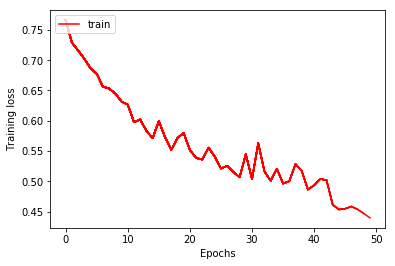

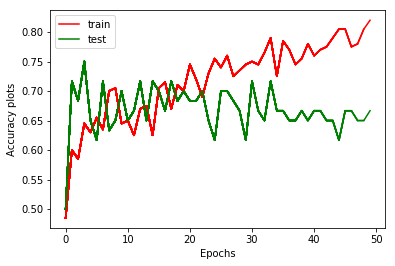

In [13]:
iterations = 50
trainLoss = []
trainAcc = []
testAcc = []
start = time.time()
for epoch in range(iterations):
    epochStart = time.time()
    runningLoss = 0
    runningCorrect = 0
    avgTrainAcc = 0
    for batch_num,data in enumerate(trainLoader):
        inputs,labels = data
        inputs = inputs/255.0
        # Initialize gradients to zero
        optimizer.zero_grad()
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            # Feed-forward input data through the network
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.cpu()
        else:
            inputs, labels = Variable(inputs), Variable(labels)  
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
        
        
        # Compute loss/error
        loss = criterion(outputs, labels)
        # Backpropagate loss and compute gradients
        loss.backward()
        # Update the network parameters
        optimizer.step()
        # Accumulate loss per batch
        runningLoss += loss.data
        runningCorrect += (predicted == labels).sum()
    avgTrainLoss = runningLoss/batch_num
    trainLoss.append(avgTrainLoss)
    avgTrainAcc = runningCorrect.item()/200.0    
    trainAcc.append(avgTrainAcc)
    
    # Evaluating performance on test set for each epoch
    net.train(False) # For testing
    inputs = TestImages/255
    if use_gpu:
        inputs = Variable(inputs.cuda())
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.cpu()
    else:
        inputs = Variable(inputs)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
    correct = 0
#     total = 0
#     total += TestLabels.size(0)
    correct += (predicted == TestLabels).sum()
    avgTestAcc = correct.item()/60.0
    testAcc.append(avgTestAcc)
    
    # Plotting training loss vs Epochs
    fig1 = plt.figure(1)        
    plt.plot(range(epoch+1),trainLoss,'r-',label='train')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Training loss')   
    # Plotting testing accuracy vs Epochs
    fig2 = plt.figure(2)        
    plt.plot(range(epoch+1),trainAcc,'r-',label='train') 
    plt.plot(range(epoch+1),testAcc,'g-',label='test')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy plots')    
    
    epochEnd = time.time()-epochStart
    print('At Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f} ; Training Acc: {:.3f} ; Testing Acc: {:.3f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainLoss,avgTrainAcc*100,avgTestAcc*100,epochEnd//60,epochEnd%60))
# end = time.time()-start
# print('Training completed in {:.0f}m {:.0f}s'.format(end//60,end%60))